# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [30]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.0
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

### LOAD DATA

In [31]:
%%time

datapath = "/g/data/es60/observations"

all_ds = xr.open_dataset(datapath + "/GOBAI-O2-v2.2.nc").squeeze()
all_ds = all_ds.rename({"pres":"depth"})
all_ds


CPU times: user 19.9 ms, sys: 38.7 ms, total: 58.6 ms
Wall time: 1.09 s


<xarray.Dataset> Size: 12GB
Dimensions:  (time: 240, depth: 58, lat: 145, lon: 360)
Coordinates:
  * lon      (lon) float32 1kB 20.5 21.5 22.5 23.5 24.5 ... 16.5 17.5 18.5 19.5
  * lat      (lat) float32 580B -64.5 -63.5 -62.5 -61.5 ... 76.5 77.5 78.5 79.5
  * depth    (depth) float32 232B 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
  * time     (time) datetime64[ns] 2kB 2004-01-15 2004-02-15 ... 2023-12-15
Data variables:
    oxy      (time, depth, lat, lon) float32 3GB ...
    temp     (time, depth, lat, lon) float32 3GB ...
    sal      (time, depth, lat, lon) float32 3GB ...
    uncer    (time, depth, lat, lon) float32 3GB ...

### Correct coordinates

In [32]:
%%time

oxy = all_ds['oxy']
tem = all_ds['temp']
sal = all_ds['sal']

oxy = oxy.roll(lon=20, roll_coords=True)
tem = tem.roll(lon=20, roll_coords=True)
sal = sal.roll(lon=20, roll_coords=True)

# Make all longitudes positive
lons = oxy.coords['lon'].values
lons[lons<0.0] += 360.0

oxy = oxy.assign_coords({"lon":lons})
tem = tem.assign_coords({"lon":lons})
sal = sal.assign_coords({"lon":lons})

lons = oxy.coords['lon'].values
lats = oxy.coords['lat'].values
deps = oxy.coords['depth'].values
time = oxy.coords['time'].values


CPU times: user 4.38 s, sys: 10.5 s, total: 14.9 s
Wall time: 22.6 s


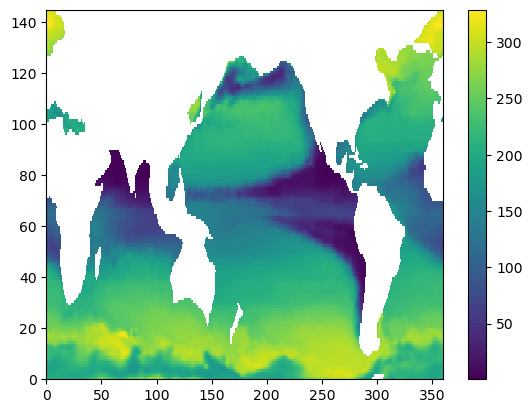

In [33]:
plt.figure()
plt.pcolormesh(oxy.sel(depth=200.0, method='nearest').isel(time=0))
plt.colorbar()


## find the oxycline depth

### regrid to a finer vertical depth grid (NOT NECESSARY, CONTINUE BELOW)

In [34]:
%%time

new_depth = np.arange(5,2001,10)
new_depth_thick = np.arange(0,2001,10)
new_depth_thick[0] = 0; new_depth_thick[-1] = 2000; 
new_depth_thick = np.diff(new_depth_thick)
print(len(new_depth), len(new_depth_thick))

new_depth_thick = new_depth_thick[:, np.newaxis, np.newaxis]
new_depth_thick = np.broadcast_to(new_depth_thick, (200,145,360))

dep_thick = xr.DataArray(
    new_depth_thick,
    dims=["depth", "lat", "lon"],
    coords={"depth": new_depth, "lon":lons, "lat":lats}
    )


200 200
CPU times: user 1.89 ms, sys: 0 ns, total: 1.89 ms
Wall time: 1.87 ms


In [40]:
%%time

tem_lin = tem.where(sal>0.0, other=np.nan).sel(depth=slice(0,2000)).interp(depth=new_depth, method='linear')
oxy_lin = oxy.where(sal>0.0, other=np.nan).sel(depth=slice(0,2000)).interp(depth=new_depth, method='linear')
sal_lin = sal.where(sal>0.0, other=np.nan).sel(depth=slice(0,2000)).interp(depth=new_depth, method='linear')

tem = tem.where(sal>0.0, other=np.nan).interpolate_na(dim='lon', method='linear').interpolate_na(dim='lat', method='linear').interpolate_na(dim='depth', method='linear')
oxy = oxy.where(sal>0.0, other=np.nan).interpolate_na(dim='lon', method='linear').interpolate_na(dim='lat', method='linear').interpolate_na(dim='depth', method='linear')
sal = sal.where(sal>0.0, other=np.nan).interpolate_na(dim='lon', method='linear').interpolate_na(dim='lat', method='linear').interpolate_na(dim='depth', method='linear')

tem = tem.where(~np.isnan(sal),other=0.0).sel(depth=slice(0,2000))
oxy = oxy.where(~np.isnan(sal),other=0.0).sel(depth=slice(0,2000))
sal = sal.where(~np.isnan(sal),other=0.0).sel(depth=slice(0,2000))

tem_cub = tem.interp(depth=new_depth, method='cubic').where(sal_lin>0.0, other=np.nan)
oxy_cub = oxy.interp(depth=new_depth, method='cubic').where(sal_lin>0.0, other=np.nan)
sal_cub = sal.interp(depth=new_depth, method='cubic').where(sal_lin>0.0, other=np.nan)


CPU times: user 19min 13s, sys: 2min 46s, total: 21min 59s
Wall time: 21min 47s


(2000.0, 0.0)

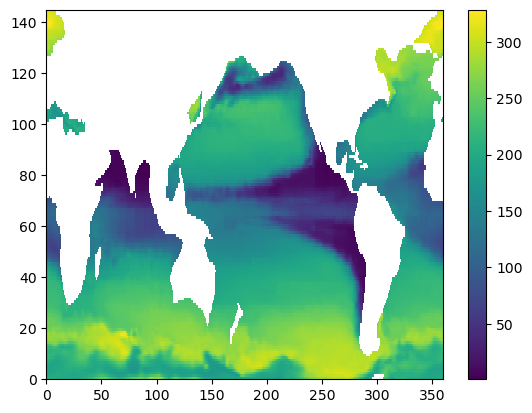

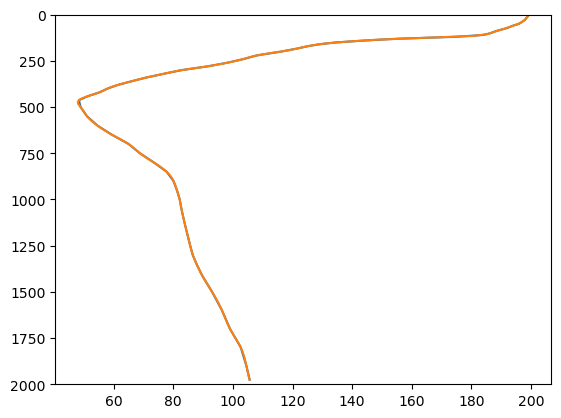

In [45]:
plt.figure()
plt.pcolormesh(oxy_cub.sel(depth=200.0, method='nearest').isel(time=0))
plt.colorbar()

plt.figure()
plt.plot(oxy.sel(lon=200.0, lat=0.0, method='nearest').isel(time=10), oxy.coords['depth'])
plt.plot(oxy_cub.sel(lon=200.0, lat=0.0, method='nearest').isel(time=10), oxy_cub.coords['depth'])
plt.ylim(2000,0)

### Calculate the oxycline

In [35]:
%%time

oxy_grad = oxy.diff(dim='depth') / oxy.coords['depth'].diff(dim='depth')
oxy_grad_min = oxy_grad.where(~np.isnan(oxy_grad), 0.0).argmin(dim='depth')
dep_3d = oxy_grad.coords['depth'].broadcast_like(oxy_grad)
oxycline = dep_3d.isel(depth=oxy_grad_min)
oxycline = oxycline.where(oxycline > 10.0, other=np.nan)

#dep_cub = oxy_cub.coords['depth']
#oxy_grad = oxy_cub.diff(dim='depth') / dep_cub.diff(dim='depth')
#oxy_grad_min = oxy_grad.where(~np.isnan(oxy_grad), 0.0).argmin(dim='depth')


CPU times: user 4.38 s, sys: 2.91 s, total: 7.29 s
Wall time: 7.4 s


<xarray.DataArray 'depth' ()> Size: 8B
array(20.)


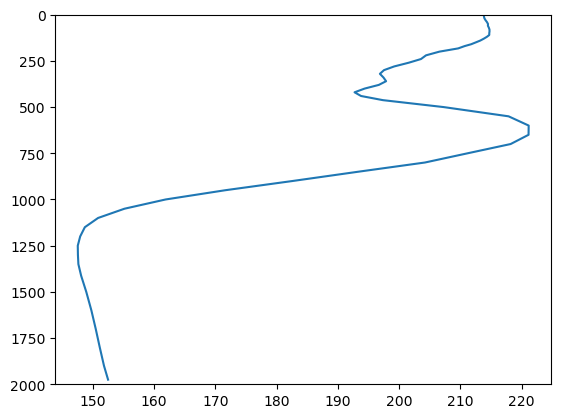

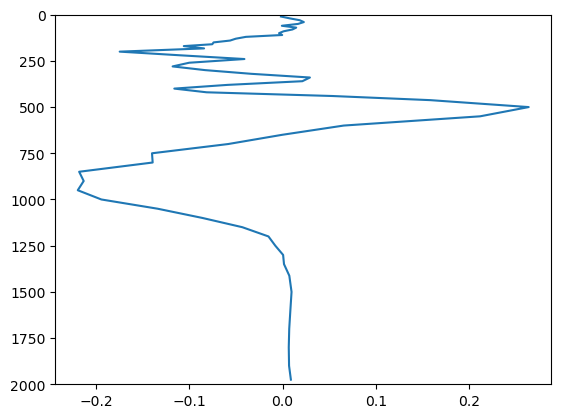

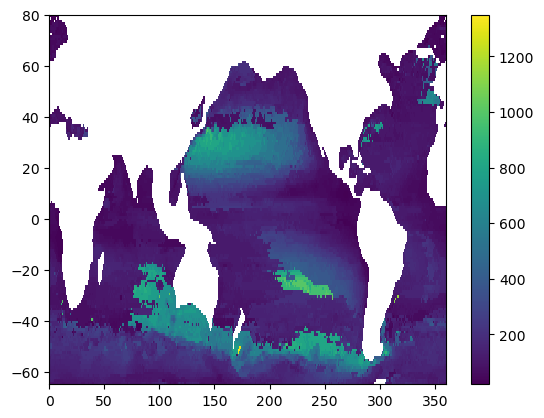

In [36]:
plt.figure()
plt.plot(oxy.sel(lon=230.0, lat=-25.0, method='nearest').isel(time=10), oxy.coords['depth'])
plt.ylim(2000,0)

plt.figure()
plt.plot(oxy_grad.sel(lon=230.0, lat=-25.0, method='nearest').isel(time=10), oxy_grad.coords['depth'])
plt.ylim(2000,0)

plt.figure()
plt.pcolormesh(lons, lats, oxycline.isel(time=10))
plt.colorbar()

print(oxycline.min())


## Calculate the depth of P50 of Skipjack Tuna (Mislan et al., 2017)
* P50 is the 50% blood saturation of O2

### Calculate the percent saturation of O2

In [37]:
%%time

# 1) Make 2D meshgrid of lat/lon:
lon_2d, lat_2d = np.meshgrid(sal.coords['lon'], sal.coords['lat'])
# lon_2d, lat_2d now each have shape (lat, lon) = (145, 360)

# 2) Broadcast them to (time, depth, lat, lon):
#    Just expand and broadcast to match sal/dep_3d
lon_4d = np.broadcast_to(lon_2d, sal.shape)
lat_4d = np.broadcast_to(lat_2d, sal.shape)
dep_4d = sal*0 + sal.coords['depth']

print(np.shape(sal))
print(np.shape(lon_4d))
print(np.shape(lat_4d))
print(np.shape(dep_4d))

asal = gsw.SA_from_SP(sal, dep_4d, lon_4d, lat_4d)
ctem = gsw.CT_from_t(asal, tem, dep_4d)
o2sat = gsw.O2sol(asal, ctem, dep_4d, lon_4d, lat_4d)



(240, 58, 145, 360)
(240, 58, 145, 360)
(240, 58, 145, 360)
(240, 58, 145, 360)
CPU times: user 4min 40s, sys: 12.4 s, total: 4min 52s
Wall time: 4min 52s


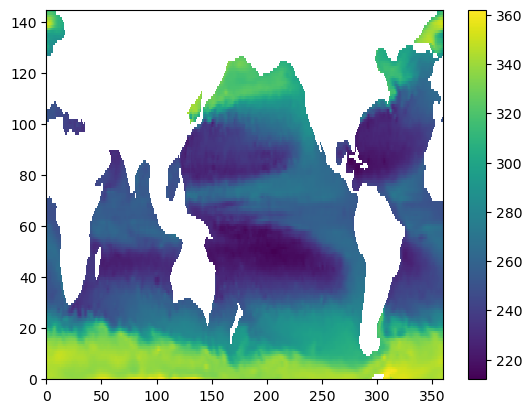

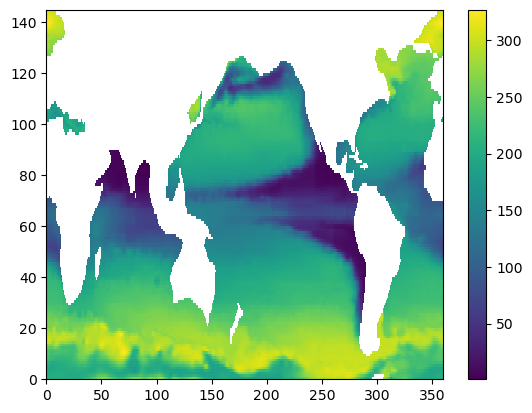

In [38]:
plt.figure()
plt.pcolormesh(o2sat.sel(depth=200.0, method='nearest').isel(time=10))
plt.colorbar()

plt.figure()
plt.pcolormesh(oxy.sel(depth=200.0, method='nearest').isel(time=10))
plt.colorbar()


### Calculate the partial pressure of O2 in kPa

CPU times: user 4.23 s, sys: 6.11 s, total: 10.3 s
Wall time: 10.4 s


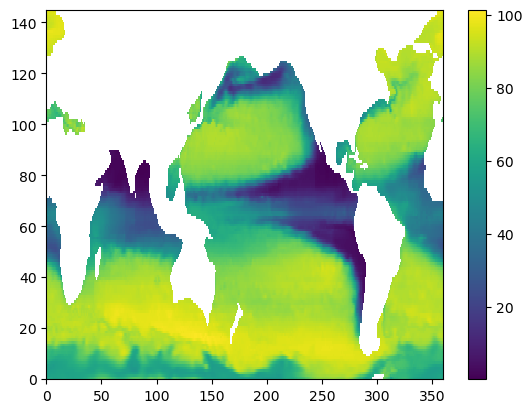

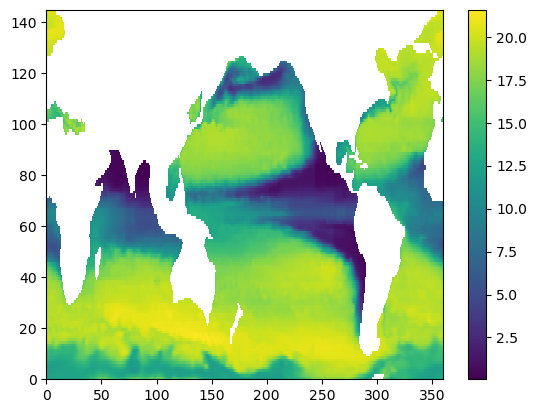

In [39]:
%%time

# 2) Convert to % saturation
pct_sat = 100.0 * oxy / o2sat

plt.figure()
plt.pcolormesh(pct_sat.sel(depth=200.0, method='nearest').isel(time=10))
plt.colorbar()

# 3) Convert from % sat to partial pressure in atm
#    Dividing by 0.21 ~ fraction of O2 in dry air
pO2_atm = (pct_sat / 100.0) * 0.21

# 4) partial pressure of O2 in kPa
pO2_kPa = pO2_atm * 101.325

plt.figure()
plt.pcolormesh(pO2_kPa.sel(depth=200.0, method='nearest').isel(time=10))
plt.colorbar()


### Calculate the P50 given in situ temperature

In [40]:
%time

# 1) Define the van't Hoff function
def compute_p50_vant_hoff(p50_ref, T_ref, T_z, deltaH, R):
    """
    p50_ref : scalar or array (reference P50 at T_ref)
    T_ref   : temperature at reference depth (e.g. 10 m), in Kelvin
    T_z     : temperature at the deeper depth(s), in Kelvin
    deltaH  : heat of oxygenation (kJ/mol)
    R       : gas constant in kJ/(mol*K)
    """
    return 10.0**(
        np.log10(p50_ref)
        - (deltaH / (2.303 * R)) * ((1.0 / T_ref) - (1.0 / T_z))
    )


# 1) Convert from Celsius to Kelvin
T_10K = (tem.isel(depth=0) + 273.15).broadcast_like(tem)
T_zK  = tem + 273.15

# 2) Choose a p50 reference and deltaH
p50_ref = 3.0            # from literature
deltaH = 1.5             # kJ/mol
R_kJ   = 0.008314        # kJ/(mol*K)

# 3) We apply compute_p50_vant_hoff using apply_ufunc:
p50_kPa = xr.apply_ufunc(
    compute_p50_vant_hoff,
    p50_ref,      # scalar -> no core dims
    T_10K,        # (time, lat, lon)
    T_zK,         # (time, depth, lat, lon)
    deltaH,       # scalar
    R_kJ,         # scalar
    input_core_dims=[
        [], 
        ['time','depth','lat','lon'], 
        ['time','depth','lat','lon'], 
        [], 
        []
    ],
    output_core_dims=[('time','depth','lat','lon')],
    vectorize=True,
    dask='parallelized',   # If using Dask
    output_dtypes=[float],
    keep_attrs=True
)



CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 8.82 μs


In [41]:
# Save ds['p50'] as the 3D P50 field
p50_kPa.name = "P50"
p50_kPa.attrs = {
    'units': 'kPa O2',
    'description': 'Blood O2 P50 computed via van’t Hoff eq.'
}

os.remove(wrkdir + "/Skipjack_O2_p50.nc")
p50_kPa.to_netcdf(wrkdir + "/Skipjack_O2_p50.nc")


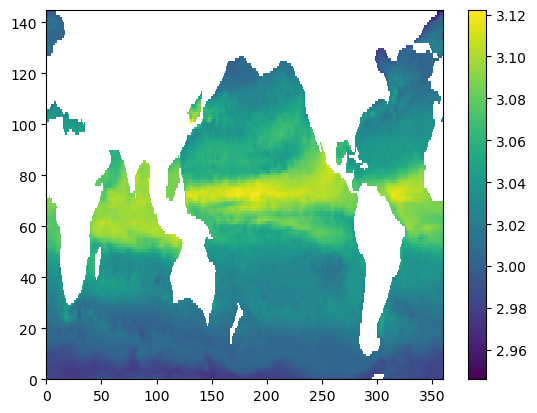

In [42]:
plt.figure()
plt.pcolormesh(p50_kPa.sel(depth=200.0, method='nearest').isel(time=10))
plt.colorbar()


## Find the depth at which P50 in ocean = Skipjack P50

CPU times: user 4.73 s, sys: 3.33 s, total: 8.06 s
Wall time: 8.07 s


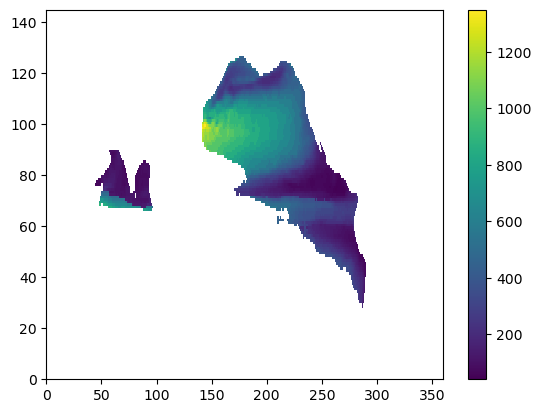

In [43]:
%%time

# Step A: define a mask: where does pO2 < p50?
mask = (pO2_kPa < p50_kPa)  # shape: (time, depth, lat, lon)
# True at each (time, depth, lat, lon) if pO2 dips below P50.

# Step B: Convert boolean -> integer so we can use idxmax
mask_int = mask.fillna(False).astype(int)
# mask.fillna(False) ensures we have no NaN booleans.

# Step C: Find if there is ANY depth where pO2 < p50
#         We'll use this to mask out points that never go below p50
any_below = mask_int.sum(dim="depth") > 0   # shape: (time, lat, lon)

# Step D: Get the coordinate of the FIRST True
#         idxmax('depth') finds the depth coordinate at which the integer
#         mask is maximum. Because all True=1, it returns the FIRST occurrence
#         of 1 along 'depth' (assuming xarray >= 0.11).
p50_critz = mask_int.idxmax(dim="depth")

# Step E: If none are True, the "max" is 0 at depth=0. We only want real hits:
p50_critz = p50_critz.where(any_below, drop=False)

p50_critz.name = "p50_dep_critical"
p50_critz.attrs["description"] = (
    "Shallowest depth at which pO2 < p50 of Skipjack"
)

plt.figure()
plt.pcolormesh(p50_critz.isel(time=10))
plt.colorbar()


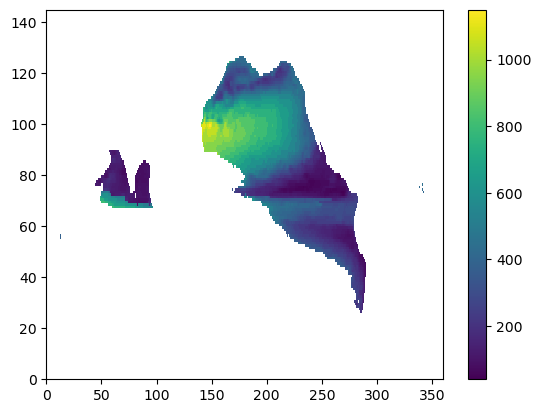

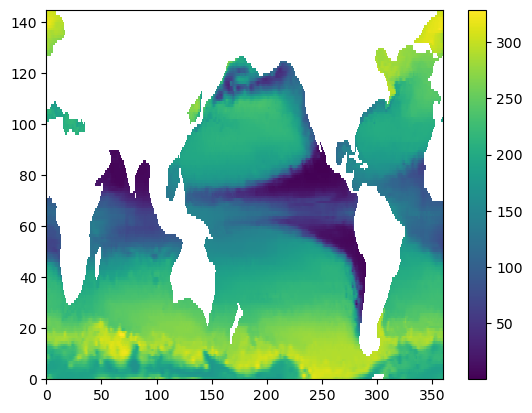

In [44]:
plt.figure()
plt.pcolormesh(p50_critz.isel(time=239))
plt.colorbar()

plt.figure()
plt.pcolormesh(oxy.isel(time=239).sel(depth=200.0, method='nearest'))
plt.colorbar()

## Take the monthly anomalies

CPU times: user 3.21 s, sys: 2.25 s, total: 5.46 s
Wall time: 8.23 s


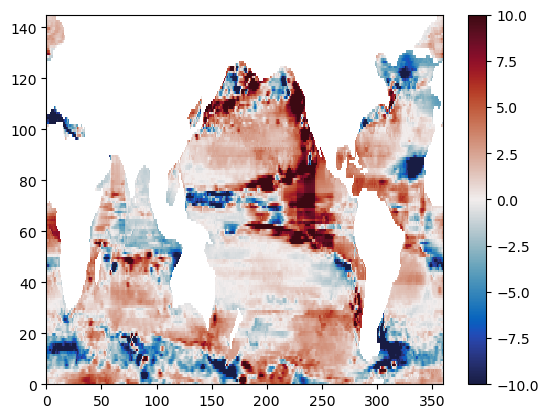

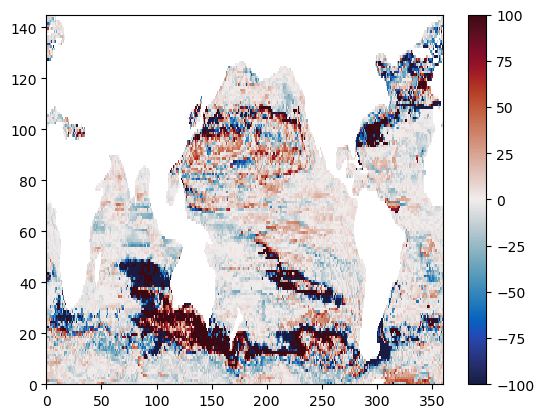

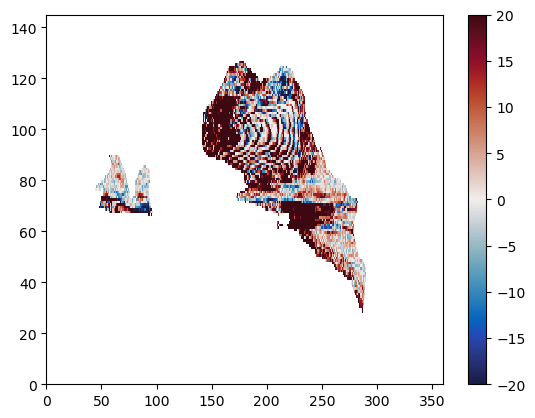

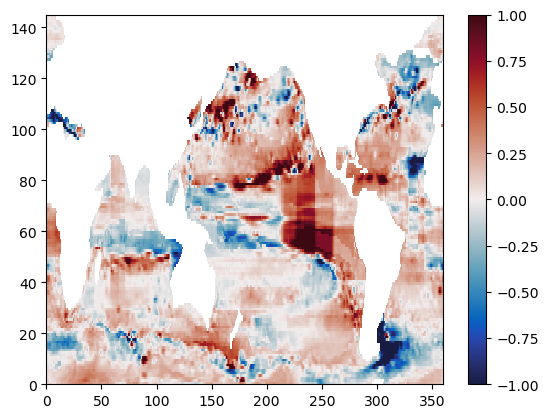

In [45]:
%%time

oxy200m = oxy.sel(depth=200.0, method='nearest')
oxy200m_clim = oxy200m.groupby('time.month').mean('time')
oxy200m_anom = oxy200m.groupby('time.month') - oxy200m_clim

oxycline_clim = oxycline.groupby('time.month').mean('time')
oxycline_anom = oxycline.groupby('time.month') - oxycline_clim

p50_critz_clim = p50_critz.groupby('time.month').mean('time')
p50_critz_anom = p50_critz.groupby('time.month') - p50_critz_clim

pO2_m_p50 = (pO2_kPa - p50_kPa)
pO2_m_p50_z50 = pO2_m_p50.sel(depth=50.0, method='nearest')
pO2_m_p50_z100 = pO2_m_p50.sel(depth=100.0, method='nearest')
pO2_m_p50_z150 = pO2_m_p50.sel(depth=150.0, method='nearest')
pO2_m_p50_z200 = pO2_m_p50.sel(depth=200.0, method='nearest')
pO2_m_p50_z250 = pO2_m_p50.sel(depth=250.0, method='nearest')
pO2_m_p50_z300 = pO2_m_p50.sel(depth=300.0, method='nearest')

pO2_m_p50_z50_clim = pO2_m_p50_z50.groupby('time.month').mean('time')
pO2_m_p50_z50_anom = pO2_m_p50_z50.groupby('time.month') - pO2_m_p50_z50_clim

pO2_m_p50_z100_clim = pO2_m_p50_z100.groupby('time.month').mean('time')
pO2_m_p50_z100_anom = pO2_m_p50_z100.groupby('time.month') - pO2_m_p50_z100_clim

pO2_m_p50_z150_clim = pO2_m_p50_z150.groupby('time.month').mean('time')
pO2_m_p50_z150_anom = pO2_m_p50_z150.groupby('time.month') - pO2_m_p50_z150_clim

pO2_m_p50_z200_clim = pO2_m_p50_z200.groupby('time.month').mean('time')
pO2_m_p50_z200_anom = pO2_m_p50_z200.groupby('time.month') - pO2_m_p50_z200_clim

pO2_m_p50_z250_clim = pO2_m_p50_z250.groupby('time.month').mean('time')
pO2_m_p50_z250_anom = pO2_m_p50_z250.groupby('time.month') - pO2_m_p50_z250_clim

pO2_m_p50_z300_clim = pO2_m_p50_z300.groupby('time.month').mean('time')
pO2_m_p50_z300_anom = pO2_m_p50_z300.groupby('time.month') - pO2_m_p50_z300_clim


plt.figure()
plt.pcolormesh(oxy200m_anom.isel(time=0), cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()

plt.figure()
plt.pcolormesh(oxycline_anom.isel(time=0), cmap=cmo.balance, vmin=-100, vmax=100)
plt.colorbar()

plt.figure()
plt.pcolormesh(p50_critz_anom.isel(time=0), cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()

plt.figure()
plt.pcolormesh(pO2_m_p50_z300_anom.isel(time=0), cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()


## Save fields

In [46]:

oxy200m.name = "oxy200m"
oxycline.name = "oxycline"
p50_critz.name = "p50_critz"
pO2_m_p50_z50.name = "pO2_m_p50_z50"
pO2_m_p50_z100.name = "pO2_m_p50_z100"
pO2_m_p50_z150.name = "pO2_m_p50_z150"
pO2_m_p50_z200.name = "pO2_m_p50_z200"
pO2_m_p50_z250.name = "pO2_m_p50_z250"
pO2_m_p50_z300.name = "pO2_m_p50_z300"

oxy200m

<xarray.DataArray 'oxy200m' (time: 240, lat: 145, lon: 360)> Size: 50MB
array([[[202.11832, 206.602  , 207.85011, ..., 198.82468, 198.42479,
         198.08862],
        [198.10252, 198.09593, 199.26802, ..., 199.04262, 199.09189,
         198.7424 ],
        [195.42598, 194.9661 , 195.00046, ..., 195.9545 , 195.74352,
         195.9293 ],
        ...,
        [316.43347, 316.69934, 316.5327 , ..., 313.8342 , 315.38177,
         316.00946],
        [311.09174, 312.58282, 312.58444, ..., 308.81845, 310.1607 ,
         311.10992],
        [311.40967, 312.1524 , 311.2375 , ..., 305.83612, 308.10706,
         309.577  ]],

       [[201.68929, 204.94704, 206.40256, ..., 198.6373 , 198.1845 ,
         197.64163],
        [198.19913, 198.06079, 199.20915, ..., 198.55301, 198.64565,
         198.7605 ],
        [195.71497, 194.95268, 195.16435, ..., 195.64433, 195.4448 ,
         195.9277 ],
...
        [307.8856 , 307.19186, 306.19873, ..., 308.1477 , 308.81693,
         308.85303],
        [303.24097, 304.0016 , 303.36624, ..., 302.41086, 303.33975,
         304.06097],
        [300.1644 , 300.3414 , 300.73535, ..., 296.50082, 298.5579 ,
         299.59296]],

       [[218.69229, 233.92021, 226.67   , ..., 200.67563, 199.37428,
         200.21692],
        [202.24503, 210.67262, 223.96391, ..., 197.71075, 198.72366,
         200.1692 ],
        [194.62317, 194.8764 , 195.16876, ..., 192.7816 , 193.01111,
         194.00986],
        ...,
        [308.92902, 308.68475, 308.08398, ..., 309.328  , 309.65643,
         309.7348 ],
        [306.5523 , 307.5081 , 306.95358, ..., 306.5168 , 307.00375,
         307.27078],
        [306.16354, 306.68845, 307.98352, ..., 301.13828, 303.2525 ,
         305.4051 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 580B -64.5 -63.5 -62.5 -61.5 ... 76.5 77.5 78.5 79.5
    depth    float32 4B 200.0
  * time     (time) datetime64[ns] 2kB 2004-01-15 2004-02-15 ... 2023-12-15
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes:
    long_name:  Dissolved Oxygen Concentration
    units:      micromoles per kilogram
    source:     machine learning scheme decribed in Sharp et al. (submitted)

In [49]:

oxy200m.name = "oxy200m"
oxycline.name = "oxycline"
p50_critz.name = "p50_critz"
pO2_m_p50_z50.name = "pO2_m_p50_z50"
pO2_m_p50_z100.name = "pO2_m_p50_z100"
pO2_m_p50_z150.name = "pO2_m_p50_z150"
pO2_m_p50_z200.name = "pO2_m_p50_z200"
pO2_m_p50_z250.name = "pO2_m_p50_z250"
pO2_m_p50_z300.name = "pO2_m_p50_z300"

os.chdir(wrkdir + "/data")

os.remove("GOBAIv2.2_oxy200m_2004-2023.nc")
os.remove("GOBAIv2.2_oxycline_2004-2023.nc")
os.remove("GOBAIv2.2_p50_critz_SJ_2004-2023.nc")
os.remove("GOBAIv2.2_pO2_m_p50_SJ_z50_2004-2023.nc")
os.remove("GOBAIv2.2_pO2_m_p50_SJ_z100_2004-2023.nc")
os.remove("GOBAIv2.2_pO2_m_p50_SJ_z150_2004-2023.nc")
os.remove("GOBAIv2.2_pO2_m_p50_SJ_z200_2004-2023.nc")
os.remove("GOBAIv2.2_pO2_m_p50_SJ_z250_2004-2023.nc")
os.remove("GOBAIv2.2_pO2_m_p50_SJ_z300_2004-2023.nc")

oxy200m.to_netcdf("GOBAIv2.2_oxy200m_2004-2023.nc")
oxycline.to_netcdf("GOBAIv2.2_oxycline_2004-2023.nc")
p50_critz.to_netcdf("GOBAIv2.2_p50_critz_SJ_2004-2023.nc")
pO2_m_p50_z50.to_netcdf("GOBAIv2.2_pO2_m_p50_SJ_z50_2004-2023.nc")
pO2_m_p50_z100.to_netcdf("GOBAIv2.2_pO2_m_p50_SJ_z100_2004-2023.nc")
pO2_m_p50_z150.to_netcdf("GOBAIv2.2_pO2_m_p50_SJ_z150_2004-2023.nc")
pO2_m_p50_z200.to_netcdf("GOBAIv2.2_pO2_m_p50_SJ_z200_2004-2023.nc")
pO2_m_p50_z250.to_netcdf("GOBAIv2.2_pO2_m_p50_SJ_z250_2004-2023.nc")
pO2_m_p50_z300.to_netcdf("GOBAIv2.2_pO2_m_p50_SJ_z300_2004-2023.nc")



## detrend the monthly anomalies

In [21]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

oxy200m_detr = xr.apply_ufunc(
    detrend_1d,
    oxy200m_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[oxy200m_anom.dtype]
)

oxycline_detr = xr.apply_ufunc(
    detrend_1d,
    oxycline_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[oxycline_anom.dtype]
)

p50_critz_detr = xr.apply_ufunc(
    detrend_1d,
    p50_critz_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[p50_critz_anom.dtype]
)

pO2_m_p50_z50_detr = xr.apply_ufunc(
    detrend_1d,
    pO2_m_p50_z50_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[pO2_m_p50_z50_anom.dtype]
)

pO2_m_p50_z100_detr = xr.apply_ufunc(
    detrend_1d,
    pO2_m_p50_z100_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[pO2_m_p50_z100_anom.dtype]
)

pO2_m_p50_z150_detr = xr.apply_ufunc(
    detrend_1d,
    pO2_m_p50_z150_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[pO2_m_p50_z150_anom.dtype]
)

pO2_m_p50_z200_detr = xr.apply_ufunc(
    detrend_1d,
    pO2_m_p50_z200_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[pO2_m_p50_z200_anom.dtype]
)

pO2_m_p50_z250_detr = xr.apply_ufunc(
    detrend_1d,
    pO2_m_p50_z250_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[pO2_m_p50_z250_anom.dtype]
)

pO2_m_p50_z300_detr = xr.apply_ufunc(
    detrend_1d,
    pO2_m_p50_z300_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[pO2_m_p50_z300_anom.dtype]
)


CPU times: user 50.2 s, sys: 4.83 s, total: 55 s
Wall time: 48.8 s


## determine the linear trends

CPU times: user 829 ms, sys: 179 ms, total: 1.01 s
Wall time: 1.25 s


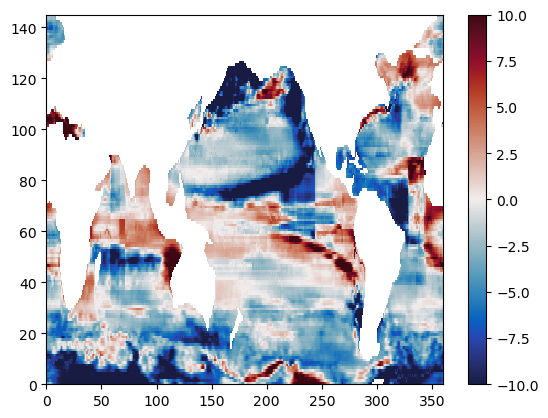

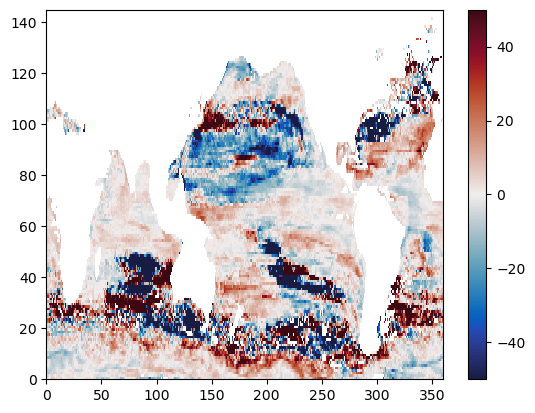

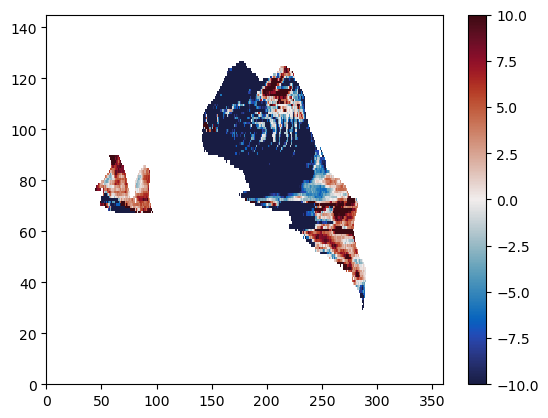

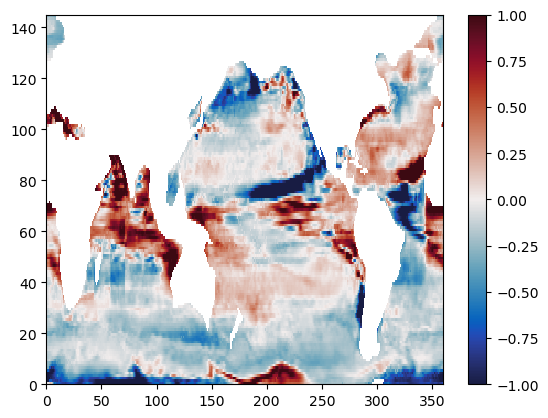

In [22]:
%%time

### retrive the linear least squares trend
oxy200m_trend = oxy200m_anom - oxy200m_detr
oxycline_trend = oxycline_anom - oxycline_detr
p50_critz_trend = p50_critz_anom - p50_critz_detr
pO2_m_p50_z50_trend = pO2_m_p50_z50_anom - pO2_m_p50_z50_detr
pO2_m_p50_z100_trend = pO2_m_p50_z100_anom - pO2_m_p50_z100_detr
pO2_m_p50_z150_trend = pO2_m_p50_z150_anom - pO2_m_p50_z150_detr
pO2_m_p50_z200_trend = pO2_m_p50_z200_anom - pO2_m_p50_z200_detr
pO2_m_p50_z250_trend = pO2_m_p50_z250_anom - pO2_m_p50_z250_detr
pO2_m_p50_z300_trend = pO2_m_p50_z300_anom - pO2_m_p50_z300_detr

### since the trends are linear, they can be described by one number (their slope)
### calculate the slope on a decadal timescale
dates = oxy200m_anom.coords['time']
oxy200m_trend = oxy200m_trend.sel(time=dates[-1]) - oxy200m_trend.sel(time=dates[0]) / len(dates) * 12 * 10
oxycline_trend = oxycline_trend.sel(time=dates[-1]) - oxycline_trend.sel(time=dates[0]) / len(dates) * 12 * 10
p50_critz_trend = p50_critz_trend.sel(time=dates[-1]) - p50_critz_trend.sel(time=dates[0]) / len(dates) * 12 * 10
pO2_m_p50_z50_trend = pO2_m_p50_z50_trend.sel(time=dates[-1]) - pO2_m_p50_z50_trend.sel(time=dates[0]) / len(dates) * 12 * 10
pO2_m_p50_z100_trend = pO2_m_p50_z100_trend.sel(time=dates[-1]) - pO2_m_p50_z100_trend.sel(time=dates[0]) / len(dates) * 12 * 10
pO2_m_p50_z150_trend = pO2_m_p50_z150_trend.sel(time=dates[-1]) - pO2_m_p50_z150_trend.sel(time=dates[0]) / len(dates) * 12 * 10
pO2_m_p50_z200_trend = pO2_m_p50_z200_trend.sel(time=dates[-1]) - pO2_m_p50_z200_trend.sel(time=dates[0]) / len(dates) * 12 * 10
pO2_m_p50_z250_trend = pO2_m_p50_z250_trend.sel(time=dates[-1]) - pO2_m_p50_z250_trend.sel(time=dates[0]) / len(dates) * 12 * 10
pO2_m_p50_z300_trend = pO2_m_p50_z300_trend.sel(time=dates[-1]) - pO2_m_p50_z300_trend.sel(time=dates[0]) / len(dates) * 12 * 10

plt.figure()
plt.pcolormesh(oxy200m_trend, cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()

plt.figure()
plt.pcolormesh(oxycline_trend, cmap=cmo.balance, vmin=-50, vmax=50)
plt.colorbar()


plt.figure()
plt.pcolormesh(p50_critz_trend, cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()

plt.figure()
plt.pcolormesh(pO2_m_p50_z100_trend, cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()



## Undertake the decomposition at each grid cell across the ocean

In [23]:
%%time

import signal
emd = EMD()

years = np.arange(2004+0.5/12, 2023+11.51/12, 1/12)
times = oxy200m_anom.coords['time'].values
lats = oxy200m_anom.coords['lat'].values
lons = oxy200m_anom.coords['lon'].values
oxy200m_imfs = np.zeros((3,len(times),len(lats),len(lons)))
oxycline_imfs = np.zeros((3,len(times),len(lats),len(lons)))
p50_critz_imfs = np.zeros((3,len(times),len(lats),len(lons)))
pO2_m_p50_z50_imfs = np.zeros((3,len(times),len(lats),len(lons)))
pO2_m_p50_z100_imfs = np.zeros((3,len(times),len(lats),len(lons)))
pO2_m_p50_z150_imfs = np.zeros((3,len(times),len(lats),len(lons)))
pO2_m_p50_z200_imfs = np.zeros((3,len(times),len(lats),len(lons)))
pO2_m_p50_z250_imfs = np.zeros((3,len(times),len(lats),len(lons)))
pO2_m_p50_z300_imfs = np.zeros((3,len(times),len(lats),len(lons)))

## Define a timeout handler
#def timeout_handler(signum, frame):
#    raise TimeoutError

## Register the timeout handler for the alarm signal
#signal.signal(signal.SIGALRM, timeout_handler)

def find_imf_freq(imfs):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])
    

def set_imfs(imfs, freqs):
    # add IMFs to the master array and merge IMFs into sub-annual, inter-annual, decadal and trend
    lentmp = np.shape(imfs)[0]
    if lentmp > 0:
        mask1 = freqs > 1                       # oscillates with period less than 1 year
        mask2 = (freqs < 1) & (freqs > 0.2)     # oscillates with period between 1 and 5 years
        mask3 = (freqs < 0.2) & (freqs > 0.0)   # oscillates with period greater than 5 years
        out1 = np.mean(imfs[mask1],axis=0)
        out2 = np.mean(imfs[mask2],axis=0)
        out3 = np.mean(imfs[mask3],axis=0)
    else:
        out1 = np.zeros(len(imfs[0,:]))
        out2 = np.zeros(len(imfs[0,:]))
        out3 = np.zeros(len(imfs[0,:]))
    return np.array([out1, out2, out3])



CPU times: user 1.71 ms, sys: 0 ns, total: 1.71 ms
Wall time: 1.45 ms


## run the loop

In [24]:
%%time

for ix,lon in enumerate(lons):
    if ix % 50 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        if np.any(np.isnan(oxy200m_detr.isel(lon=ix, lat=iy).values)):
            continue
        else:
            oxy200mimfs = emd(oxy200m_detr.isel(lon=ix, lat=iy).values, max_imf=5)

        # determine the frequencies of the IMFs
        oxy200m_freqs = find_imf_freq(oxy200mimfs)
        # add IMFs to the master array and merge IMFs into sub-annual, inter-annual, decadal and trend
        oxy200m_imfs[:,:,iy,ix] = set_imfs(oxy200mimfs, oxy200m_freqs)
        
        
for ix,lon in enumerate(lons):
    if ix % 50 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        if np.any(np.isnan(oxycline_detr.isel(lon=ix, lat=iy).values)):
            continue
        elif np.all(oxycline_detr.isel(lon=ix, lat=iy).values == 0.0):
            continue
        else:
            oxyclineimfs = emd(oxycline_detr.isel(lon=ix, lat=iy).values, max_imf=5)

        oxycline_freqs = find_imf_freq(oxyclineimfs)
        oxycline_imfs[:,:,iy,ix] = set_imfs(oxyclineimfs, oxycline_freqs)
        

for ix,lon in enumerate(lons):
    if ix % 50 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        if np.any(np.isnan(p50_critz_detr.isel(lon=ix, lat=iy).values)):
            continue
        elif np.all(p50_critz_detr.isel(lon=ix, lat=iy).values == 0.0):
            continue
        else:
            p50_critzimfs = emd(p50_critz_detr.isel(lon=ix, lat=iy).values, max_imf=5)

        p50_critz_freqs = find_imf_freq(p50_critzimfs)
        p50_critz_imfs[:,:,iy,ix] = set_imfs(p50_critzimfs, p50_critz_freqs)
        

for ix,lon in enumerate(lons):
    if ix % 50 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        if np.any(np.isnan(pO2_m_p50_z50_detr.isel(lon=ix, lat=iy).values)):
            continue
        else:
            pO2_m_p50_z50imfs = emd(pO2_m_p50_z50_detr.isel(lon=ix, lat=iy).values, max_imf=5)

        pO2_m_p50_z50_freqs = find_imf_freq(pO2_m_p50_z50imfs)
        pO2_m_p50_z50_imfs[:,:,iy,ix] = set_imfs(pO2_m_p50_z50imfs, pO2_m_p50_z50_freqs)
        

for ix,lon in enumerate(lons):
    if ix % 50 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        if np.any(np.isnan(pO2_m_p50_z100_detr.isel(lon=ix, lat=iy).values)):
            continue
        else:
            pO2_m_p50_z100imfs = emd(pO2_m_p50_z100_detr.isel(lon=ix, lat=iy).values, max_imf=5)
        
        pO2_m_p50_z100_freqs = find_imf_freq(pO2_m_p50_z100imfs)
        pO2_m_p50_z100_imfs[:,:,iy,ix] = set_imfs(pO2_m_p50_z100imfs, pO2_m_p50_z100_freqs)
        

for ix,lon in enumerate(lons):
    if ix % 50 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        if np.any(np.isnan(pO2_m_p50_z150_detr.isel(lon=ix, lat=iy).values)):
            continue
        else:
            pO2_m_p50_z150imfs = emd(pO2_m_p50_z150_detr.isel(lon=ix, lat=iy).values, max_imf=5)
        
        pO2_m_p50_z150_freqs = find_imf_freq(pO2_m_p50_z150imfs)
        pO2_m_p50_z150_imfs[:,:,iy,ix] = set_imfs(pO2_m_p50_z150imfs, pO2_m_p50_z150_freqs)
        

for ix,lon in enumerate(lons):
    if ix % 50 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        if np.any(np.isnan(pO2_m_p50_z200_detr.isel(lon=ix, lat=iy).values)):
            continue
        else:
            pO2_m_p50_z200imfs = emd(pO2_m_p50_z200_detr.isel(lon=ix, lat=iy).values, max_imf=5)

        pO2_m_p50_z200_freqs = find_imf_freq(pO2_m_p50_z200imfs)
        pO2_m_p50_z200_imfs[:,:,iy,ix] = set_imfs(pO2_m_p50_z200imfs, pO2_m_p50_z200_freqs)
        
        

for ix,lon in enumerate(lons):
    if ix % 50 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        if np.any(np.isnan(pO2_m_p50_z250_detr.isel(lon=ix, lat=iy).values)):
            continue
        else:
            pO2_m_p50_z250imfs = emd(pO2_m_p50_z250_detr.isel(lon=ix, lat=iy).values, max_imf=5)

        pO2_m_p50_z250_freqs = find_imf_freq(pO2_m_p50_z250imfs)
        pO2_m_p50_z250_imfs[:,:,iy,ix] = set_imfs(pO2_m_p50_z250imfs, pO2_m_p50_z250_freqs)


for ix,lon in enumerate(lons):
    if ix % 50 == 0:
        print(ix)
    for iy,lat in enumerate(lats):
        if np.any(np.isnan(pO2_m_p50_z300_detr.isel(lon=ix, lat=iy).values)):
            continue
        else:
            pO2_m_p50_z300imfs = emd(pO2_m_p50_z300_detr.isel(lon=ix, lat=iy).values, max_imf=5)
        
        pO2_m_p50_z300_freqs = find_imf_freq(pO2_m_p50_z300imfs)
        pO2_m_p50_z300_imfs[:,:,iy,ix] = set_imfs(pO2_m_p50_z300imfs, pO2_m_p50_z300_freqs)




0


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


50
100
150
200
250
300
350
0
50
100
150
200
250
300
350
0
50
100
150
200
250
300
350
0
50
100
150
200
250
300
350
0
50
100
150
200
250
300
350
0
50
100
150
200
250
300
350
0
50
100
150
200
250
300
350
0
50
100
150
200
250
300
350
0
50
100
150
200
250
300
350
CPU times: user 1h 16min 56s, sys: 6.27 s, total: 1h 17min 2s
Wall time: 1h 17min 4s


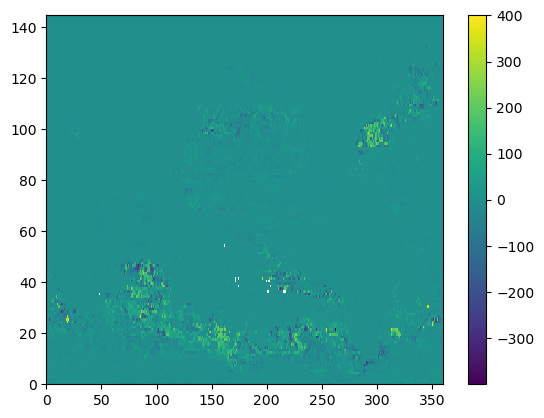

In [26]:
oxy200m_detr.transpose("time","lat","lon")
oxy200m_anom

plt.figure()
plt.pcolormesh(oxycline_imfs[0,0,:,:])
plt.colorbar()

In [27]:

# Create xarray Datasets
imfs_oxy200m_ds = xr.Dataset(
    {
        "oxy200m_imfs": (["IMF", "time", "lat", "lon"], oxy200m_imfs),
        "oxy200m_anom": (["time", "lat", "lon"], oxy200m_anom.values),
        "oxy200m_detr": (["time", "lat", "lon"], oxy200m_detr.transpose("time","lat","lon").values),
        "oxy200m_trend": (["lat", "lon"], oxy200m_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

imfs_oxycline_ds = xr.Dataset(
    {
        "oxycline_imfs": (["IMF", "time", "lat", "lon"], oxycline_imfs),
        "oxycline_anom": (["time", "lat", "lon"], oxycline_anom.values),
        "oxycline_detr": (["time", "lat", "lon"], oxycline_detr.transpose("time","lat","lon").values),
        "oxycline_trend": (["lat", "lon"], oxycline_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

imfs_p50_critz_ds = xr.Dataset(
    {
        "p50_critz_imfs": (["IMF", "time", "lat", "lon"], p50_critz_imfs),
        "p50_critz_anom": (["time", "lat", "lon"], p50_critz_anom.values),
        "p50_critz_detr": (["time", "lat", "lon"], p50_critz_detr.transpose("time","lat","lon").values),
        "p50_critz_trend": (["lat", "lon"], p50_critz_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

imfs_pO2_m_p50_z50_ds = xr.Dataset(
    {
        "pO2_m_p50_z50_imfs": (["IMF", "time", "lat", "lon"], pO2_m_p50_z50_imfs),
        "pO2_m_p50_z50_anom": (["time", "lat", "lon"], pO2_m_p50_z50_anom.values),
        "pO2_m_p50_z50_detr": (["time", "lat", "lon"], pO2_m_p50_z50_detr.transpose("time","lat","lon").values),
        "pO2_m_p50_z50_trend": (["lat", "lon"], pO2_m_p50_z50_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

imfs_pO2_m_p50_z100_ds = xr.Dataset(
    {
        "pO2_m_p50_z100_imfs": (["IMF", "time", "lat", "lon"], pO2_m_p50_z100_imfs),
        "pO2_m_p50_z100_anom": (["time", "lat", "lon"], pO2_m_p50_z100_anom.values),
        "pO2_m_p50_z100_detr": (["time", "lat", "lon"], pO2_m_p50_z100_detr.transpose("time","lat","lon").values),
        "pO2_m_p50_z100_trend": (["lat", "lon"], pO2_m_p50_z100_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

imfs_pO2_m_p50_z150_ds = xr.Dataset(
    {
        "pO2_m_p50_z150_imfs": (["IMF", "time", "lat", "lon"], pO2_m_p50_z150_imfs),
        "pO2_m_p50_z150_anom": (["time", "lat", "lon"], pO2_m_p50_z150_anom.values),
        "pO2_m_p50_z150_detr": (["time", "lat", "lon"], pO2_m_p50_z150_detr.transpose("time","lat","lon").values),
        "pO2_m_p50_z150_trend": (["lat", "lon"], pO2_m_p50_z150_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

imfs_pO2_m_p50_z200_ds = xr.Dataset(
    {
        "pO2_m_p50_z200_imfs": (["IMF", "time", "lat", "lon"], pO2_m_p50_z200_imfs),
        "pO2_m_p50_z200_anom": (["time", "lat", "lon"], pO2_m_p50_z200_anom.values),
        "pO2_m_p50_z200_detr": (["time", "lat", "lon"], pO2_m_p50_z200_detr.transpose("time","lat","lon").values),
        "pO2_m_p50_z200_trend": (["lat", "lon"], pO2_m_p50_z200_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

imfs_pO2_m_p50_z250_ds = xr.Dataset(
    {
        "pO2_m_p50_z250_imfs": (["IMF", "time", "lat", "lon"], pO2_m_p50_z250_imfs),
        "pO2_m_p50_z250_anom": (["time", "lat", "lon"], pO2_m_p50_z250_anom.values),
        "pO2_m_p50_z250_detr": (["time", "lat", "lon"], pO2_m_p50_z250_detr.transpose("time","lat","lon").values),
        "pO2_m_p50_z250_trend": (["lat", "lon"], pO2_m_p50_z250_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

imfs_pO2_m_p50_z300_ds = xr.Dataset(
    {
        "pO2_m_p50_z300_imfs": (["IMF", "time", "lat", "lon"], pO2_m_p50_z300_imfs),
        "pO2_m_p50_z300_anom": (["time", "lat", "lon"], pO2_m_p50_z300_anom.values),
        "pO2_m_p50_z300_detr": (["time", "lat", "lon"], pO2_m_p50_z300_detr.transpose("time","lat","lon").values),
        "pO2_m_p50_z300_trend": (["lat", "lon"], pO2_m_p50_z300_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)



os.chdir(wrkdir + "/data/")

os.remove("imfs_oxy200m.nc")
os.remove("imfs_oxycline.nc")
os.remove("imfs_p50_critz.nc")
os.remove("imfs_pO2_m_p50_z50.nc")
os.remove("imfs_pO2_m_p50_z100.nc")
os.remove("imfs_pO2_m_p50_z150.nc")
os.remove("imfs_pO2_m_p50_z200.nc")
os.remove("imfs_pO2_m_p50_z250.nc")
os.remove("imfs_pO2_m_p50_z300.nc")

imfs_oxy200m_ds.to_netcdf("imfs_oxy200m.nc")
imfs_oxycline_ds.to_netcdf("imfs_oxycline.nc")
imfs_p50_critz_ds.to_netcdf("imfs_p50_critz.nc")
imfs_pO2_m_p50_z50_ds.to_netcdf("imfs_pO2_m_p50_z50.nc")
imfs_pO2_m_p50_z100_ds.to_netcdf("imfs_pO2_m_p50_z100.nc")
imfs_pO2_m_p50_z150_ds.to_netcdf("imfs_pO2_m_p50_z150.nc")
imfs_pO2_m_p50_z200_ds.to_netcdf("imfs_pO2_m_p50_z200.nc")
imfs_pO2_m_p50_z250_ds.to_netcdf("imfs_pO2_m_p50_z250.nc")
imfs_pO2_m_p50_z300_ds.to_netcdf("imfs_pO2_m_p50_z300.nc")
